# Segundo modelo

Series temporales utilizando como predictores únicamente los datos propios del Índice IBEX 35. Este índice integra las cotizaciones de las 35 empresas más importantes de España. Es un índice ponderado según la capitalización bursatil de las 35 empresas que lo componen; es decir, las empresas que tienen una mayor capitalización tiene más peso en el índice.
El dataset con el que trabajaremos dispone de las siguientes variables:
- fecha, día de la muestra
- último, valor de cierre del índice expresado en puntos para ese día (unidad puntos)
- apertura, valor de apertura del índice expresado en puntos para ese día
- máximo, valor máximo alcanzado del índice expresado en puntos para ese día
- mínimo, valor mínimo alcanzado del índice expresado en puntos para ese día
- volumen, número de operaciones de compraventa cerradas para ese día (unidad millones)
- variación, variación del valor del índice con respecto al día anterior (unidad %)
- deuda_publica, conjunto de deudas que mantiene el Estado español frente a los particulares que pueden ser españoles o de otro país
- ipc, indicador que mide la variación de los precios de una cesta de bienes y servicios en un lugar concreto durante un determinado periodo de tiempo
- tasa_paro, mide el nivel de desocupación en relación con la población activa
- pib, suma de todos los bienes y servicios finales que produce un país o una economía, elaborados dentro del territorio nacional tanto por empresas nacionales como extranjeras, y que se registran en un periodo determinado

La variable a predecir:  
- el valor último o de cierre

En esta primera prueba vamos a utilizar el dataset con los datos desde el 12-02-2015. Se filtra por esta fecha porque viene marcado por el dataset de AENA que sólo tiene datos desde esa fecha. Además las variables exogenas que utilizamos no tienen datos desde el año 1991.

## Carga de las librerías y datos

In [1]:
import numpy as np
import pandas as pd
import pandas as pdBb
import glob
import datetime
import warnings
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn")
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.externals import joblib
import statsmodels.api as sm
from sklearn import metrics

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Definimos tres funciones:
- get_all_historic_data(): retorna el histórico de datos existentes en el directorio /dataset/NOMBRE_INDICE/final_historic_data_with_metrics_NOMBRE_INDICE_[all / filter_by_20150212].csv. Dependiendo de si tiene activo el filtro filter_year retornará todos los datos o únicamente los existentes a partir del 12-02-2015. Estos dataset se generan de forma automática en el script 01_Generate_historic_data.py.
El método recibe como parámetros el nombre del índice y el flag que indica que datos desea obtener y retorna un dataframe.
- transform_data(): realiza una serie de transformaciones sobre el dataframe de entrada. Recibe como parámetro de entrada un dataframe y retorna el mismo dataframe con las transformaciones necesarias.
- fill_pending_dates(): se encarga de añadir todas las fechas no presentes en el dataset. Recibe como parámetros de entrada un dataframe y el tipo de frecuencia deseada para la serie temporal.

In [2]:
def get_all_historic_data(name_index, filter_year):
    # Cargamos todo el histórico de datos que tenemos de IBEX35
    if(filter_year==False):
        filename = './dataset/' + name_index + '/final_historic_data_with_metrics_' + name_index + '_all.csv'
    else:
        filename = './dataset/' + name_index + '/final_historic_data_with_metrics_' + name_index + '_filter_by_20150212.csv'
    final_historic_data = pd.read_csv(filename)
    
    # Aplicamos las transformaciones que nos hacen falta
    # Cambiamos el valor "-" de la columna vol a NaN
    final_historic_data["vol"] = final_historic_data["vol"].replace("-", np.NaN)
    # Necesitamos convertir la columna Fecha a Date
    final_historic_data['fecha'] =  pd.to_datetime(final_historic_data['fecha'], format = "%Y-%m-%d", errors ='coerce')
    # Ordenamos los registros por la fecha
    final_historic_data.sort_values(by=('fecha'),ascending=True)
    
    data_total = pd.DataFrame(final_historic_data, columns=["fecha","ultimo","apertura","maximo","minimo","vol","variacion",
                                                           "deuda_publica", "ipc", "tasa_paro", "pib"])
    return data_total

# Función que aplica las transformaciones en el volumen
def convert_cash(item):
    transform = {'B': 10**3, 'M': 1}
    try:
        item_transform = item[-1]
        return float(item[:-1]) * transform[item_transform]
    except TypeError:
        return item
    
# Función que aplica una serie de transformaciones al dataset
def transform_data(data, columns_drop, colums_type):
    # Cambiamos el formato de miles y decimales de todas las columnas
    data = data.replace(r'[.]','', regex=True)
    data = data.replace(r'[,]','.', regex=True)
    # Quitamos las columnas que vengan indicadas en el parámetro columns_drop
    data = data.drop(columns_drop, axis=1)
    if 'vol' in data.columns:
        # Volumen: existen dos tipos de unidades (M millones) y (B billones)
        # Se harán dos transformaciones:
        # - (M millones) vamos a quitar la unidad y no haremos la transformación en los datos
        # - (B billones) vamos a quitar la unidad y multiplicamos por 1000
        data['vol'] = data['vol'].map(lambda x: convert_cash(x) if (pd.notnull(x)) else x)   
    if 'variacion' in data.columns:
        # Variación: vamos a quitar el % aunque no haremos la transformación en los datos 
        data['variacion'] = data['variacion'].map(lambda x: x.rstrip('%') if (pd.notnull(x)) else x)
    # Utilizamos la función fillna() con el método "forward fill" de forma que los valores no nulos se copien hacia
    # adelante siempre que se encuentren valores nulos en las columnas: deuda_publica, ipc, tasa_paro y pib
    if 'deuda_publica' in data.columns:
        data['deuda_publica'].fillna(method='ffill', inplace=True)
    if 'ipc' in data.columns:
        data['ipc'].fillna(method='ffill', inplace=True)
    if 'tasa_paro' in data.columns:
        data['tasa_paro'].fillna(method='ffill', inplace=True)
    if 'pib' in data.columns:
        data['pib'].fillna(method='ffill', inplace=True)
    # Convertimos los NaN a 0
    data = data.fillna(0)
    # Convertimos las columnas a los formatos indicados en el parámetro columns_type
    data = data.astype(colums_type)
    # Ordenamos el dataset por fecha en orden ascendente
    data = data.sort_values(by=["fecha"])
    # Ponemos la columna date como índice
    data.set_index("fecha", inplace=True)
    # Ordenamos los índices
    data.sort_index(inplace=True)
    return data

# Función que rellena todas las fechas que faltan en el dataset
def fill_pending_dates(data, type_freq):
    ref_date_range = pd.date_range(start = data.index.min(), end = data.index.max(), freq=type_freq)
    data = data.reindex(ref_date_range)
    return data

## Análisis exploratorio de los datos (EDA)

Llamamos a la función para obtener el histórico de datos del índice IBEX35 y mostramos el total de elementos.

In [3]:
data_total = get_all_historic_data('IBEX35',True)
data_total.shape

(1423, 11)

Visualizamos una pequeña muestra del dataset.

In [4]:
data_total.head()

,fecha,ultimo,apertura,maximo,minimo,vol,variacion,deuda_publica,ipc,tasa_paro,pib
0,2015-02-12,"10.562,20","10.349,60","10.607,10","10.328,50","328,00M","1,90%","1.044.720,44","-1,07","23,78","1,15"
1,2015-02-13,"10.739,50","10.618,50","10.794,90","10.606,70","427,94M","1,68%","1.044.720,44","-1,07","23,78","1,15"
2,2015-02-16,"10.689,50","10.717,80","10.793,10","10.679,90","220,58M","-0,47%","1.044.720,44","-1,07","23,78","1,15"
3,2015-02-17,"10.698,00","10.591,60","10.730,10","10.526,60","272,47M","0,08%","1.044.720,44","-1,07","23,78","1,15"
4,2015-02-18,"10.805,30","10.764,60","10.852,60","10.764,10","298,37M","1,00%","1.044.720,44","-1,07","23,78","1,15"


En este primer modelo de series temporales únicamente vamos a tener en cuenta para entrenar el modelo el predictor. Posteriormente realizaremos un segundo modelo utilizando las mismas variables que aplicamos en la Regresión Múltiple.
Llamamos a la función para que realice las transformaciones necesarias en el dataset y lo mostramos de forma gráfica.

In [5]:
data_total = transform_data(data_total,['apertura', 'maximo', 'minimo', 'vol', 'variacion','deuda_publica', 'ipc',
                                       'tasa_paro', 'pib'], {"ultimo": float})

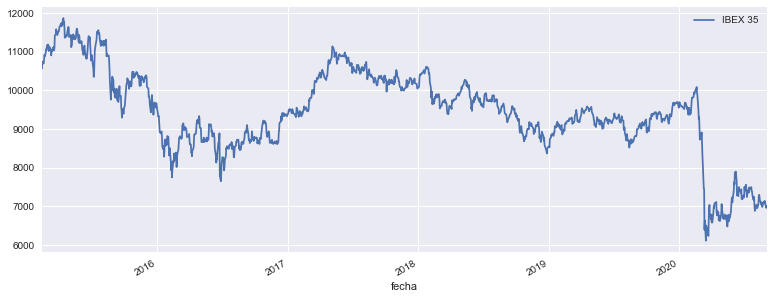

In [6]:
fig, ax = plt.subplots(figsize=(13,5))
data_total.plot(ax=ax)
ax.legend(["IBEX 35"])
plt.show()

Deberemos validar que el dataset este completo para todas las fechas del periodo B (días laborales). Para eso realizaremos la validación que tenemos a continuación. En caso de no presentar todos los datos será necesario llamar a la función fill_pending_dates()

In [7]:
# Validamos si existen todos los índices en el dataset. En caso de existir índices pendientes será necesario llamar
# a la función fill_pending_dates()
ref_date_range = pd.date_range(start = data_total.index.min(), end = data_total.index.max(), freq='B')
ref_date_range
ref_df = pd.DataFrame(np.random.randint(1, 20, (ref_date_range.shape[0], 1)))
ref_df.index = ref_date_range
missing_dates = ref_df.index[~ref_df.index.isin(data_total.index)]
missing_dates

DatetimeIndex(['2015-04-03', '2015-04-06', '2015-05-01', '2015-12-25',
               '2016-01-01', '2016-03-25', '2016-03-28', '2016-12-26',
               '2017-04-14', '2017-04-17', '2017-05-01', '2017-12-25',
               '2017-12-26', '2018-01-01', '2018-03-30', '2018-04-02',
               '2018-05-01', '2018-12-25', '2018-12-26', '2019-01-01',
               '2019-04-19', '2019-04-22', '2019-05-01', '2019-12-25',
               '2019-12-26', '2020-01-01', '2020-04-10', '2020-04-13',
               '2020-05-01', '2020-06-01'],
              dtype='datetime64[ns]', freq=None)

In [8]:
data_total = fill_pending_dates(data_total, "B")
data_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1452 entries, 2015-02-12 to 2020-09-04
Freq: B
Data columns (total 1 columns):
ultimo    1422 non-null float64
dtypes: float64(1)
memory usage: 22.7 KB


In [9]:
data_total.head()

,ultimo
2015-02-12,10562.2
2015-02-13,10739.5
2015-02-16,10689.5
2015-02-17,10698.0
2015-02-18,10805.3


Vamos a acceder al índice de un missing date para ver que efectivamente se han agregado correctamente. Por defecto veremos que el valor añadido es NaN; en este caso, para que no interfiera en el modelo hemos decidido que se rellene con el valor "ultimo" de la fecha anterior.

In [10]:
# Valor previo al missing value
data_total.loc['2017-04-13']

ultimo    10326.1
Name: 2017-04-13 00:00:00, dtype: float64

In [11]:
# Valor del missing value
data_total.loc['2017-04-14']

ultimo   NaN
Name: 2017-04-14 00:00:00, dtype: float64

In [12]:
# Utilizamos la función fillna() con el método "forward fill" de forma que los valores no nulos se copien hacia
# adelante siempre que se encuentren valores nulos.
data_total.fillna(method='ffill', inplace=True)

In [13]:
# Validamos que ha tomado el valor correcto
data_total.loc['2017-04-14']

ultimo    10326.1
Name: 2017-04-14 00:00:00, dtype: float64

In [14]:
# Y no existan más nulos
data_total['ultimo'].isnull().sum()

0

En nuestra caso la serie temporal tiene un periodo B (días laborales); establecemos dicho periodo y mostramos la información de forma gráfica.

In [15]:
# Establecemos el periodo B (business day frequency) de Lúnes a Viernes
data_total = data_total.to_period("B")
# Existen periodos de muchos tipos
data_total.head()

,ultimo
2015-02-12,10562.2
2015-02-13,10739.5
2015-02-16,10689.5
2015-02-17,10698.0
2015-02-18,10805.3


In [16]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1452 entries, 2015-02-12 to 2020-09-04
Freq: B
Data columns (total 1 columns):
ultimo    1452 non-null float64
dtypes: float64(1)
memory usage: 22.7 KB


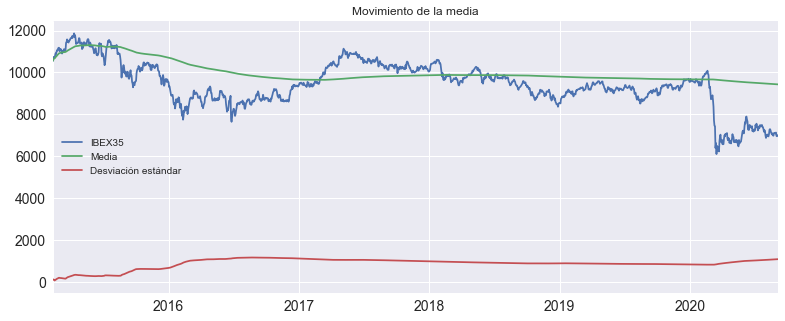

In [17]:
# Función para calcular los movimientos de la media
def mean_movement(data, window):
    # Obtenemos la media y desviación estándar de los datos
    data_mean = data_total.rolling(window, min_periods=1).mean()
    data_std = data_total.rolling(window, min_periods=1).std()
    # Pintamos la gráfica
    plt.rcParams["figure.figsize"] = (16,8)
    data_total.ultimo.plot(figsize=(13,5), label='IBEX35', fontsize=14)
    data_mean.ultimo.plot(figsize=(13,5), label='Media', fontsize=14)
    data_std.ultimo.plot(figsize=(13,5), label='Desviación estándar', fontsize=14)
    plt.legend(loc='best')
    plt.title('Movimiento de la media')
    plt.show()

mean_movement(data_total, 2000)

Analizando a simple vista esta serie podemos observar que existe una tendencia a decrecer a largo plazo, se trata de una serie Heterocedástica ya que la variabilidad de la serie aumenta y disminuye a lo largo del tiempo y no se trata de datos cíclicos ya que no existe un patrón.
Esta tendencia al alza ya nos indica que nuestros datos no son estacionarios, ya que la media y la desviación típica varían año a año al alza.

### Test de Dickey-Fuller
Aunque ya en la gráfica anterior podíamos ver que nuestros datos no son estacionarios para asegurarnos al 100% podemos realizar algún test de estacionalidad. Este test básicamente lo que hace es eliminar las autocorrelaciones de los datos y probar si son estacionarios.

In [18]:
# Función para calcular el test de Dickey-Fuller
def stationary_dickeyfuller_test(data):
    print("Resultados del test de Dickey-Fuller aumentada (ADF):")
    df_test = adfuller(data, autolag='AIC')
    df_results = pd.Series(df_test[:4], index=['Test Statistic', 'P-Value', 'Lags used', 'Number of observations used'])
    return df_results

# Llamamos a la función para obtener los resultados de la función de Dickey-Fuller
stationary_dickeyfuller_test(data_total.ultimo)

Resultados del test de Dickey-Fuller aumentada (ADF):


Test Statistic                   -1.724738
P-Value                           0.418414
Lags used                         2.000000
Number of observations used    1449.000000
dtype: float64

En este caso la hipótesis nula es que nuestros datos son estacionarios, para eso se tiene que dar que el P-valor sea menor de 0.05 y que el Test estadístico sea lo más negativo posible. En nuestro caso se cumple ambas condiciones con lo que podemos confirmar que no se cumple la hipótesis nula y por tanto nuestros datos NO son estacionarios.

### Seasonal decompose
Por último vamos a realizar una descomposición de los datos para evaluar los distintos elementos de una serie temporal por separado:
- Tendencia: el aumento o disminución a largo plazo de los datos.
- Estacional o periódico: si la serie está influenciada por factores estacionales; esta siempre existe en una serie.
- Cíclico: si existen subidas y bajadas que no son del periodo fijo; se denomina patrón cíclico.
Analizar estas gráficas nos proporciona información esencial para decidir que módelos aplicar o con qué parámetros.


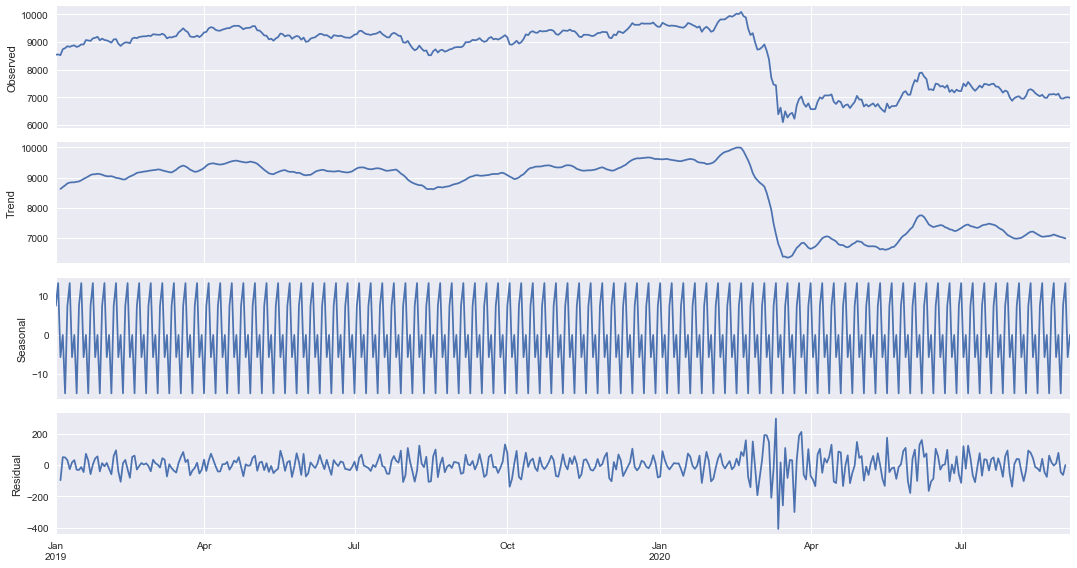

In [19]:
# En nuestro caso como el periodo es B (business day frequency) de Lúnes a Viernes, el valor freq esperado es de 5
res = sm.tsa.seasonal_decompose(data_total.ultimo.truncate(before = "2019").dropna(), freq=5)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

- 1º gráfica: nos muestra los datos observados con un pequeño suavizado.
- 2º gráfica: nos muestra la tendencia. En este gráfico como la visualización sólo nos muestra desde el año 2019 no se aprecia pero la tendencia a la largo plazo en este caso es ascendente
- 3º gráfica: nos aisla el patrón y podemos ver como el patrón se repite constantemente.
- 4º gráfica: los residuos que se muestran aleatorios y con una media constante.

### Aplicar transformación a los datos para conseguir estacionariedad
Como vimos anteriormente en el test de Dickey-Fuller no se cumple la hipótesis nula y por tanto nuestros datos NO son estacionarios. Para conseguir estacionariedad vamos a utilizar la diferencia de una serie consigo misma tras desplazarla 1 lag. 
Los datos dependen mucho entre si y no se trata de una serie estacionaria para ello vamos a utilizar la diferencia de una serie consigo mismo tras desplazarla 1 lag.

In [20]:
data_total_diff = data_total - data_total.shift(1)
data_total_diff.dropna(inplace = True)
data_total_diff.head()

,ultimo
2015-02-13,177.3
2015-02-16,-50.0
2015-02-17,8.5
2015-02-18,107.3
2015-02-19,105.1


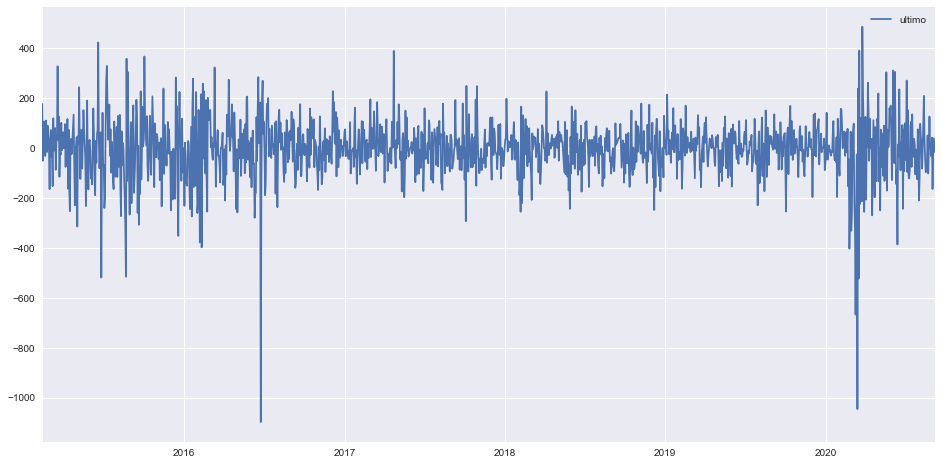

In [21]:
plt.rcParams["figure.figsize"] = (16,8)
data_total_diff.plot()
plt.show()

Comprobamos que calculando la diferencia de una serie consigo misma tras desplazarla un lag mejoramos su estacionariedad. Esta visualización sugiere que la estacionaridad y tendencia han sido eliminados por la diferenciación 

### Autocorrelación simple y autocorrelación parcial
La configuración del modelo ARIMA, depende del tipo de serie temporal que queremos predecir. Alguna de las características que hay que tener en cuenta son la autocorrelación y la autocorrelación parcial de los datos. A partir de sus gráficas podremos ajustar mejor los parámetros del modelo.
Para poder analizar la serie es necesario identificar la estructura que la genera, es decir cómo influyen las observaciones del pasado en las observaciones del futuro. Esta dependencia se puede identificar utilizando dos fuentes de información:

- Función de Autocorrelación simple (FAS): proporciona la estructura de dependencia lineal de la misma. La idea de la función es proporcionar un coeficiente de correlación entre las observaciones separadas un número determinado de periodos.
- Función de Autocorrelación parcial (FAP): proporciona la relación directa que existe entre observaciones separadas por k retardos cuando no se considera la dependencia creada por los retardos intermedios existentes entre ambas.

La función ACF es usada para identificar el proceso de media móvil (MA) en un modelo ARIMA; mientras que la función PACF se usa para identificar los valores de la parte del proceso autoregresivo (AR).

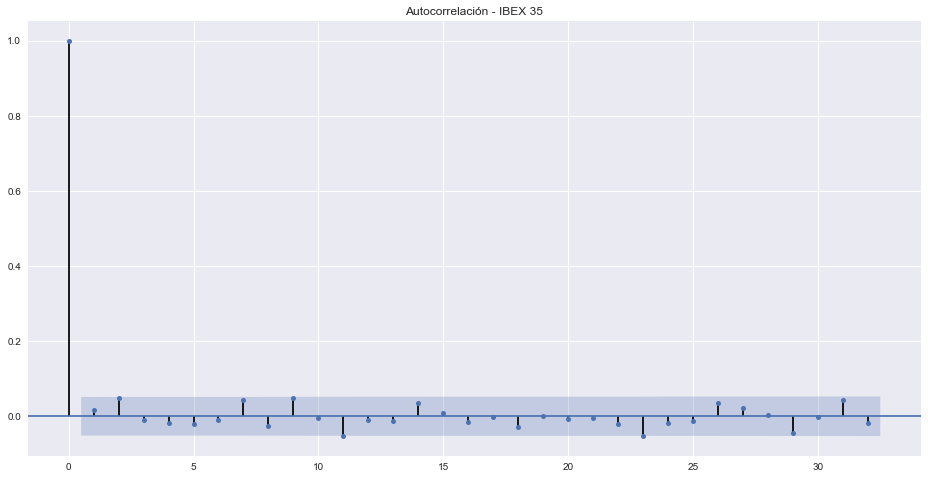

In [22]:
# FAS: Función de autocorrelación simple
acf = plot_acf(data_total_diff, unbiased=True)
plt.title('Autocorrelación - IBEX 35')
plt.show()

Como se puede observar la función de autocorrelación proporciona los coeficientes de correlación de la serie consigo misma para distintos retardos. En este caso los coeficientes son significativos para los retardos 2, 11 y 23; esto es así, porque los límites para considerar significativo un retardo son todos aquellos coeficientes que se encuentren fuera de la sombra azul. Esto indica que una observación influye bastante sobre las que están muy alejadas de ella.

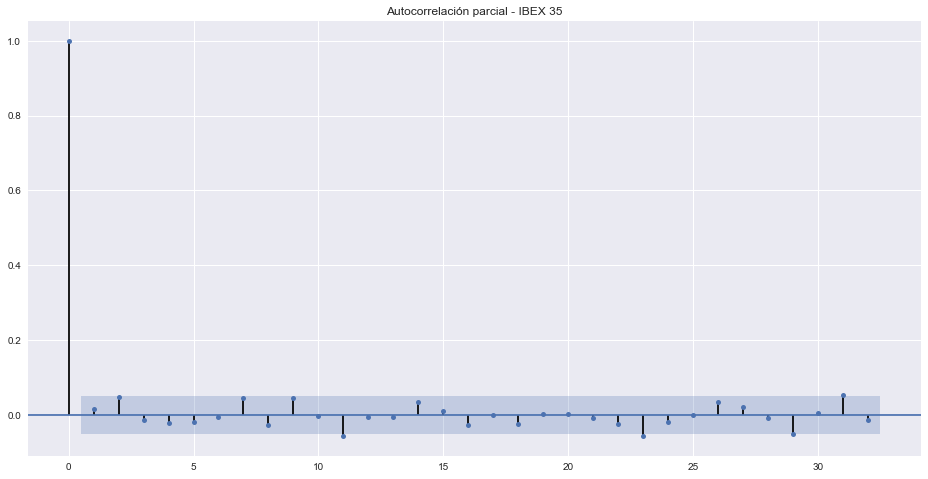

In [23]:
# FAP: Función de autocorrelación parcial
pacf = plot_pacf(data_total_diff)
plt.title('Autocorrelación parcial - IBEX 35')
plt.show()

Aquí podemos observar que segundo (entre otros) retardo son significativos, mientras que el resto no lo es.

Analizando ambas gráficas podemos indicar que el coeficiente de correlación muestral es significativo porque sobrepasa el límite de la prueba de hipótesis en la FAS y FAP por lo tanto existe autocorrelación. 
También podemos observar examinando ambas gráficos que NO posee componentes estacionales.

Tras este análisis, podemos justificar que el modelo que se deberá utilizar es ARIMA(p,d,q); cuyo valor como parámetro d será igual 1. Para el resto de parámetros se obtendrán con el método AIC.

## Ajuste de un modelo ARIMA(p,d,q)

En nuestro caso la serie no es estacionaria, debemos aplicar un modelo ARIMA(p,d,q). Donde p denota el número de términos autoregresivos, d el número de veces que la serie debe ser diferenciada para hacerla estacionaria y q el número de términos de la media móvil invertible.
De los análisis anteriores podemos establecer los siguientes parámetros:
- p; gráfico función de autocorrelación parcial
- d=1; número de diferenciaciones necesarias para conseguir que la serie sea estacionaria
- q; gráfico función de autocorrelación simple

El modelo ARIMA es un modelo estadístico que utiliza variaciones y regresiones de datos estadísticos con el fin de encontrar patrones para una predicción hacia el futuro. Se trata de un modelo dinámico de series temporales, es decir, las estimaciones futuras vienen explicadas por los datos del pasado y no por variables independientes.

In [25]:
# Definimos los datos de train y test
train = data_total[0:1432]
test = data_total[1432:]

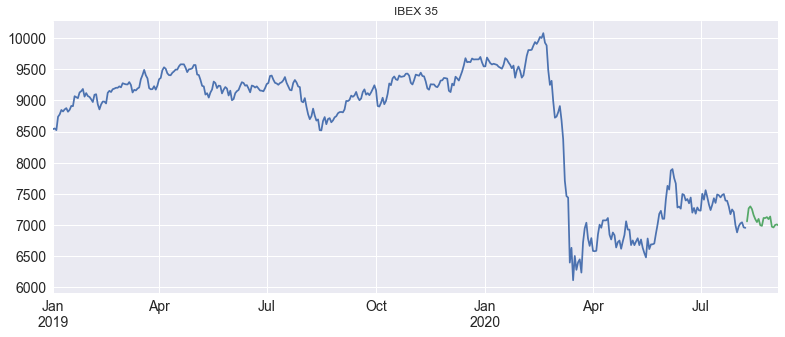

In [26]:
# Visualizamos los datos train y test 
train.ultimo.truncate(before = "2019").plot(figsize=(13,5), title='IBEX 35', fontsize=14)
test.ultimo.plot(figsize=(13,5), title='IBEX 35', fontsize=14)
plt.show()

El siguiente paso será estimar los parámetros p y q para el modelo ARIMA(). Para escoger cuál de los distintas opciones vamos a escoger nos vamos a basar en el crítero AIC.
- Criterio BIC: trata de seleccionar el modelo correcto, con máxima probabilidad a posteriori, y puede demostrarse que es un criterio consistente de manera que la probabilidad de seleccionar el modelo correcto tiende a 1 cuando aumenta el tamaño muestral. Asume que el modelo real está incluido en el conjunto de modelos candidatos, y mide el grado de certeza de que un cierto modelo sea el verdadero modelo generador de los datos.
- Critero AIC: no pretende seleccionar el modelo correcto, ya que admite que el modelo verdadero puede no estar entre los estimados tratando de obtener el modelo que proporcione mejores predicciones entre los existentes. No asume que ninguno de los modelos candidatos sea necesariamente el verdadero, calculando para cada modelo la información o discrepancia de Kullback-Leibler, que es una medida de la distancia entre la densidad de probabilidad generada por el modelo y la realidad.

In [27]:
p = q = range(0,4)
pdq = [(x[0], 1, x[1]) for x in list (itertools.product(p,q))]
res_parameters = []
for param in pdq:
    try:
        mod=SARIMAX(train, order=param, enforce_stationarity=False)
        results = mod.fit()
        res_parameters.append({'param': param, 'aic': results.aic, 'bic': results.bic})
    except:
        continue

res_aic_bic = pd.DataFrame(res_parameters)
print("Parámetros p y q que minimizan la paramétrica AIC:")
print(res_aic_bic[res_aic_bic.aic == res_aic_bic.aic.min()])
print("\nParámetros p y q que minimizan la paramétrica BIC:")
print(res_aic_bic[res_aic_bic.bic == res_aic_bic.bic.min()])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Parámetros p y q que minimizan la paramétrica AIC:
        param           aic           bic
11  (2, 1, 3)  17605.536186  17637.116164

Parámetros p y q que minimizan la paramétrica BIC:
       param           aic           bic
3  (0, 1, 3)  17611.680155  17632.733473


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [28]:
res_aic_bic

,param,aic,bic
0,"(0, 1, 0)",17644.958443,17650.223873
1,"(0, 1, 1)",17635.076492,17645.605952
2,"(0, 1, 2)",17621.923071,17637.715161
3,"(0, 1, 3)",17611.680155,17632.733473
4,"(1, 1, 0)",17646.587488,17657.118347
5,"(1, 1, 1)",17635.653211,17651.447402
6,"(1, 1, 2)",17623.894676,17644.950797
7,"(1, 1, 3)",17612.911689,17639.228337
8,"(2, 1, 0)",17633.482983,17649.277173
9,"(2, 1, 1)",17635.407572,17656.466493


En nuestro caso como comentamos anteriormente vamos a tener en cuenta los parámetros que retornen un menor AIC; en este caso el modelo ARIMA resultante sería ARIMA(2,1,3).

### 01. Entrenamiento modelo ARIMA(2,1,3) y representación de los resultados para un único predictor

In [29]:
# Primer modelo de Series temporales > ARIMA (Proceso autoregresivo integrado y de media móvil)
model01_st_arima213 = SARIMAX(train.to_timestamp(), order=(2,1,3), enforce_stationarity=False).fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [30]:
model01_st_arima213.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                 ultimo   No. Observations:                 1432
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -8796.768
Date:                Sat, 05 Sep 2020   AIC                          17605.536
Time:                        11:22:17   BIC                          17637.116
Sample:                    02-12-2015   HQIC                         17617.330
                         - 08-07-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9044      0.021     42.155      0.000       0.862       0.946
ar.L2         -0.9146      0.023    -40.552      0.000      -0.959      -0.870
ma.L1         -0.8965      0.027    -33.183      0.000      -0.949      -0.844
ma.L2          0.9490      0.025     38.261      0.000       0.900       0.998
ma.L3          0.0110      0.020      0.545      0.585      -0.029       0.051
sigma2      1.334e+04    242.777     54.948      0.000    1.29e+04    1.38e+04
===================================================================================
Ljung-Box (Q):                       38.06   Jarque-Bera (JB):              8007.21
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -1.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

En este resumen de los datos debemos centrar la atención en la columna coef; esta nos muestra la importancia de cada característica y cómo afecta a la serie temporal. El p-value también nos muestra el nivel de significancia del peso de cada variable. Casi todas tienen un p-value menor de 0.5 a excepción de ma.L3 pero la dejaremos en el modelo ya que minimiza la paramétrica AIC.

El siguiente punto será evaluar los residuos obtenidos en el modelo; los cuales deben aproximarse al comportamiento de ruido blanco. Deben presentar media cero, varianza constante y convarianza cero (incorrelación).

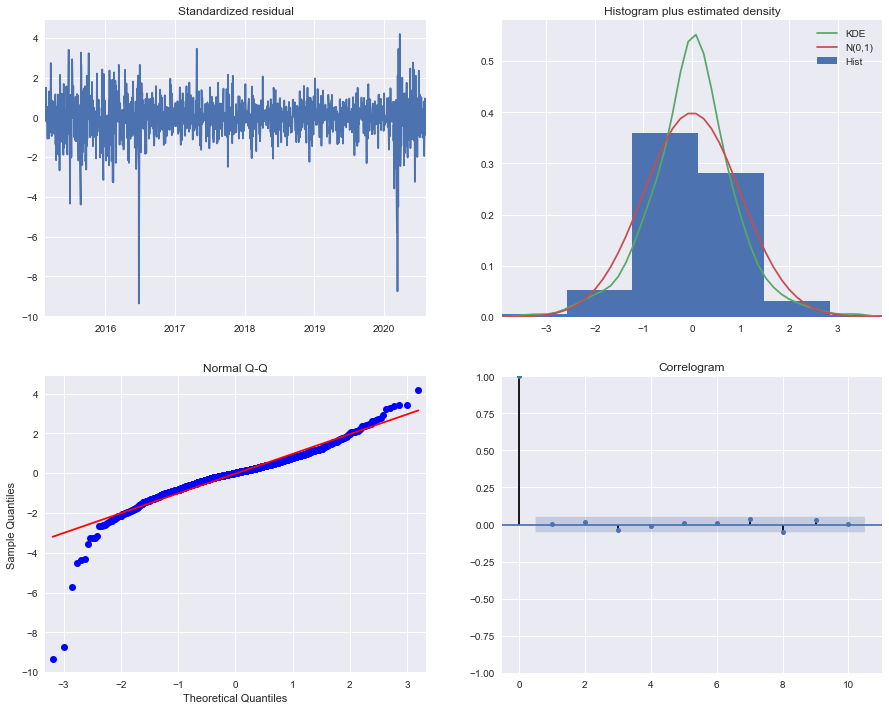

In [31]:
model01_st_arima213.plot_diagnostics(figsize=(15, 12))
plt.show()

- Gráfica Standardized residual: podemos observar que los residuos giran alrededor de una media cero.
- Gráfica Histogram plus estimated density: podemos observar que se comportan de manera aproximadamente normal.
- Gráfica Normal Q-Q: podemos observar que se comportan de manera aproximadamente normal. 
- Gráfica Correlogram: podemos observar que no existe correlación entre los residuos del modelo.

A continuación vamos a predicir una serie de resultados y plotear los resultados mostrando los resultados de confianza sobre dichas prediciones.

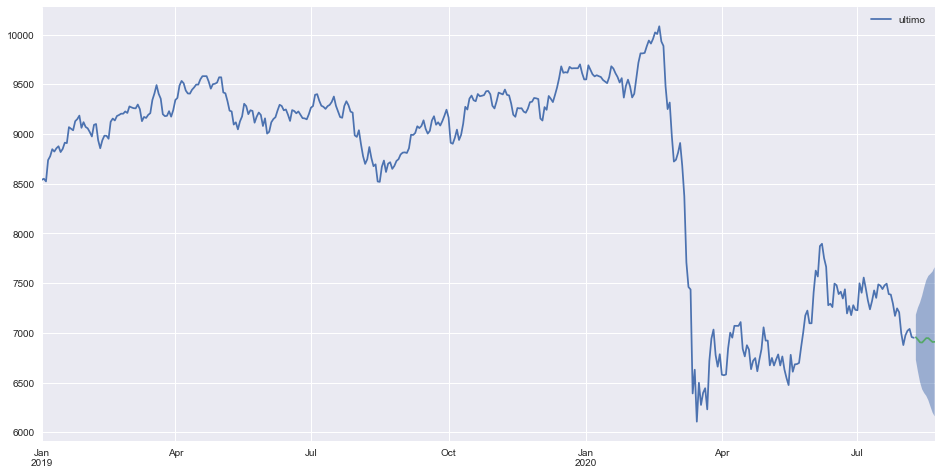

In [32]:
y_pred = model01_st_arima213.get_forecast(10)

lower = y_pred.conf_int()["lower ultimo"]
upper = y_pred.conf_int()["upper ultimo"]
train.truncate(before = "2019").plot()

y_pred.predicted_mean.plot()
plt.fill_between(lower.index, lower, upper, alpha =0.5)
plt.show()

Finalmente vamos a calcular el MSE para validar como de bueno es nuestro modelo y poderlo comparar con el resto de modelos.

In [33]:
# Finalmente debemos comprobar cómo de eficiente es nuestro modelo
# MSE: Mean squared error
print("- TRAIN -")
print("Mean squared error: %.2f" % metrics.mean_squared_error(train.ultimo, model01_st_arima213.fittedvalues))

- TRAIN -
Mean squared error: 113270.22


Aplicamos la técnica de Cross Validation sobre los datos de train; como nuestras observaciones no son independientes no podemos dividir los datos al azar utilizando K-folds para ello será necesario utilizar TimeSeriesSplit de Scikit-learn.
TimeSeriesSplit es una variante adaptada de K-folds que va iterando los "folds" de uno a uno (usando una ventana de tiempo que se desplaza) y usando el "fold más reciente" como el set de validación.

In [34]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for train_index, test_index in tscv.split(train):
    X_tr, X_val = train.iloc[train_index, :], train.iloc[test_index, :]
    y_tr, y_val = train.iloc[train_index], train.iloc[test_index]
    model = SARIMAX(X_tr.to_timestamp(), order=(2,1,3), enforce_stationarity=False).fit()
    score.append(metrics.mean_squared_error(X_tr.ultimo, model.fittedvalues))
    
print("- TRAIN -")
print("Cross-Validation > Mean squared error: %.2f" % np.mean(np.array(score)))

- TRAIN -
Cross-Validation > Mean squared error: 241875.08


Guardamos el modelo para usarlo posteriormente con los valores de test:

In [35]:
path_model_save = "./models/arima213_fit_ultimo_python.pkl"  
joblib.dump(model01_st_arima213, path_model_save)

['./models/arima213_fit_ultimo_python.pkl']

Cargamos el modelo guardado para usarlo con los modelos de test:

In [36]:
model01_st_arima213 = joblib.load(path_model_save)

Ahora sobre el modelo entrenado vamos a predecir valores sobre el dataset de test. Como podemos observar las prediciones no son muy buenas pero hay que tener en cuenta que durante ese periodo se produjo la crisis del COVID-19

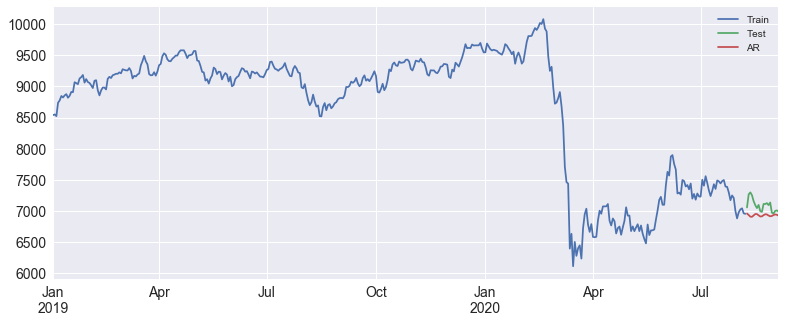

In [37]:
# Primer modelo de Series temporales > AR (Modelo autorregresivo)
test2 = test.to_timestamp()
y_pred_test = test2.copy()
y_pred_test['AR'] = model01_st_arima213.predict(n_periods=len(test2), start=test2.index.min(), end=test2.index.max())
y_pred_test

plt.figure(figsize=(16,8))
train.ultimo.truncate(before = "2019").plot(figsize=(13,5), label='Train', fontsize=14)
test.ultimo.plot(figsize=(13,5), label='Test', fontsize=14)
y_pred_test.AR.plot(figsize=(13,5), label='AR', fontsize=14)
plt.legend(loc='best')
plt.show()

In [38]:
# Finalmente debemos comprobar cómo de eficiente es nuestro modelo sobre los datos de test
# MSE: Mean squared error
print("- TEST -")
print("Mean squared error: %.2f" % metrics.mean_squared_error(test.ultimo, y_pred_test.AR))

- TEST -
Mean squared error: 35144.21


Si nos fijamos el MSE en train es de 241875,08 mientras que el MSE en test es de 35144,21; si este valor estuviera muy por encima del MSE de train esto sería un indicador de que nuestro modelo no ha entrenado bien y no nos sirve. Podría tratarse de un caso de Overfiting.

### 02. Entrenamiento modelo ARIMA(p,1,q) y representación de los resultados para los predictores deuda_publica, ipc, tasa_paro y pib

Lo primero que tenemos que hacer es obtener el dataset con los datos que necesitamos.

In [39]:
data_total_with_predict = get_all_historic_data('IBEX35',True)
data_total_with_predict = transform_data(data_total_with_predict, ['maximo', 'minimo', 'variacion', 'apertura','vol'], 
                                         {"ultimo": float, "deuda_publica": float, "ipc": float, "tasa_paro": float, 
                                         "pib": float})
data_total_with_predict = fill_pending_dates(data_total_with_predict, "B")
data_total_with_predict.head()

,ultimo,deuda_publica,ipc,tasa_paro,pib
2015-02-12,10562.2,1044720.44,-1.07,23.78,1.15
2015-02-13,10739.5,1044720.44,-1.07,23.78,1.15
2015-02-16,10689.5,1044720.44,-1.07,23.78,1.15
2015-02-17,10698.0,1044720.44,-1.07,23.78,1.15
2015-02-18,10805.3,1044720.44,-1.07,23.78,1.15


En nuestra caso la serie temporal tiene un periodo B (días laborales); establecemos dicho periodo y mostramos la información de forma gráfica.

In [40]:
# Establecemos el periodo B (business day frequency) de Lúnes a Viernes
data_total_with_predict = data_total_with_predict.to_period("B")
# Existen periodos de muchos tipos
data_total_with_predict.head()

,ultimo,deuda_publica,ipc,tasa_paro,pib
2015-02-12,10562.2,1044720.44,-1.07,23.78,1.15
2015-02-13,10739.5,1044720.44,-1.07,23.78,1.15
2015-02-16,10689.5,1044720.44,-1.07,23.78,1.15
2015-02-17,10698.0,1044720.44,-1.07,23.78,1.15
2015-02-18,10805.3,1044720.44,-1.07,23.78,1.15


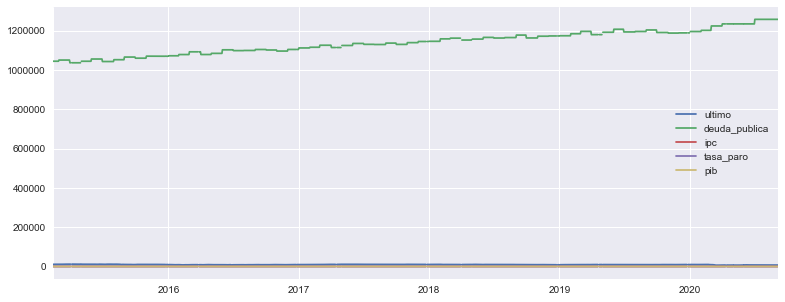

In [41]:
fig, ax = plt.subplots(figsize=(13,5))
# Para no escribir este tamaño siempre se va a establecer una variable de configuración y todas las figuras saldrán 
# de ese tamaño sin necesidad de escribir la primera línea
plt.rcParams["figure.figsize"] = (13,5)
data_total_with_predict.plot(ax=ax);

Será necesario rellenar los valores núlos de las variables exogenous; para ello vamos a utilizar el método "forward fill" (los valores no nulos se copian hacia adelante siempre que se encuentren valores nulos).

In [42]:
# Utilizamos la función fillna() con el método "forward fill" de forma que los valores no nulos se copien hacia
# adelante siempre que se encuentren valores nulos.
data_total_with_predict.fillna(method='ffill', inplace=True)

In [43]:
data_total_with_predict

,ultimo,deuda_publica,ipc,tasa_paro,pib
2015-02-12,10562.2,1044720.44,-1.07,23.78,1.15
2015-02-13,10739.5,1044720.44,-1.07,23.78,1.15
2015-02-16,10689.5,1044720.44,-1.07,23.78,1.15
2015-02-17,10698.0,1044720.44,-1.07,23.78,1.15
2015-02-18,10805.3,1044720.44,-1.07,23.78,1.15
...,...,...,...,...,...
2020-08-31,6969.5,1257818.96,-0.60,15.33,-18.50
2020-09-01,6956.9,1257818.96,-0.60,15.33,-18.50
2020-09-02,6996.9,1257818.96,-0.60,15.33,-18.50
2020-09-03,7006.0,1257818.96,-0.60,15.33,-18.50


In [44]:
# Definimos los datos de train y test
train_with_predict = data_total_with_predict[0:1432]
test_with_predict = data_total_with_predict[1432:]

In [45]:
train_with_predict.tail()

,ultimo,deuda_publica,ipc,tasa_paro,pib
2020-08-03,6975.0,1257818.96,-0.6,15.33,-18.5
2020-08-04,7021.6,1257818.96,-0.6,15.33,-18.5
2020-08-05,7039.7,1257818.96,-0.6,15.33,-18.5
2020-08-06,6957.9,1257818.96,-0.6,15.33,-18.5
2020-08-07,6950.5,1257818.96,-0.6,15.33,-18.5


El siguiente paso será estimar los parámetros p y q para el modelo ARIMA(). Para escoger cuál de los distintas opciones vamos a escoger nos vamos a basar en el crítero AIC.
- Criterio BIC: trata de seleccionar el modelo correcto, con máxima probabilidad a posteriori, y puede demostrarse que es un criterio consistente de manera que la probabilidad de seleccionar el modelo correcto tiende a 1 cuando aumenta el tamaño muestral. Asume que el modelo real está incluido en el conjunto de modelos candidatos, y mide el grado de certeza de que un cierto modelo sea el verdadero modelo generador de los datos.
- Critero AIC: no pretende seleccionar el modelo correcto, ya que admite que el modelo verdadero puede no estar entre los estimados tratando de obtener el modelo que proporcione mejores predicciones entre los existentes. No asume que ninguno de los modelos candidatos sea necesariamente el verdadero, calculando para cada modelo la información o discrepancia de Kullback-Leibler, que es una medida de la distancia entre la densidad de probabilidad generada por el modelo y la realidad.

In [46]:
p = q = range(0,4)
pdq = [(x[0], 1, x[1]) for x in list (itertools.product(p,q))]
res_parameters_with_predict = []
for param in pdq:
    try:
        mod=SARIMAX(train_with_predict.iloc[:, 0], 
                         exog=train_with_predict.iloc[:,1:], 
                         order=param,
                         #seasonal_order=(0,0,0,0),
                         freq='B',
                         enforce_stationary=False,
                         enforce_invertibility=False)
        results = mod.fit()
        res_parameters_with_predict.append({'param': param, 'aic': results.aic, 'bic': results.bic})
    except:
        continue

res_aic_bic_with_predict = pd.DataFrame(res_parameters_with_predict)
print("Parámetros p y q que minimizan la paramétrica AIC:")
print(res_aic_bic_with_predict[res_aic_bic_with_predict.aic == res_aic_bic_with_predict.aic.min()])
print("\nParámetros p y q que minimizan la paramétrica BIC:")
print(res_aic_bic_with_predict[res_aic_bic_with_predict.bic == res_aic_bic_with_predict.bic.min()])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Parámetros p y q que minimizan la paramétrica AIC:
        param           aic           bic
15  (3, 1, 3)  17659.303958  17717.231375

Parámetros p y q que minimizan la paramétrica BIC:
       param           aic           bic
0  (0, 1, 0)  17663.310278  17689.640922


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Entrenamos el modelo ARIMA(3,1,3) con nuestras variables exogenous.

In [47]:
# Segundo modelo de Series temporales > ARIMA(3,1,3)
train_with_predict = train_with_predict.to_timestamp()
model02_st_arima313 = SARIMAX(train_with_predict.iloc[:, 0], 
                         exog=train_with_predict.iloc[:,1:], 
                         order=(3,1,3),
                         #seasonal_order=(0,0,0,0),
                         freq='B',
                         enforce_stationary=False,
                         enforce_invertibility=False).fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [48]:
model02_st_arima313.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                 ultimo   No. Observations:                 1432
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -8818.652
Date:                Sat, 05 Sep 2020   AIC                          17659.304
Time:                        11:29:40   BIC                          17717.231
Sample:                    02-12-2015   HQIC                         17680.935
                         - 08-07-2020                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
deuda_publica     0.0005      0.002      0.237      0.813      -0.004       0.005
ipc              48.6503     41.133      1.183      0.237     -31.970     129.270
tasa_paro        -8.7949     42.369     -0.208      0.836     -91.837      74.248
pib               7.0300     12.339      0.570      0.569     -17.154      31.214
ar.L1             0.2047      0.535      0.383      0.702      -0.844       1.253
ar.L2            -0.2624      0.496     -0.529      0.597      -1.235       0.710
ar.L3            -0.6926      0.499     -1.387      0.165      -1.671       0.286
ma.L1            -0.2155      0.541     -0.399      0.690      -1.275       0.844
ma.L2             0.3057      0.503      0.608      0.543      -0.680       1.291
ma.L3             0.7043      0.525      1.340      0.180      -0.326       1.734
sigma2         1.333e+04    243.426     54.774      0.000    1.29e+04    1.38e+04
===================================================================================
Ljung-Box (Q):                       36.05   Jarque-Bera (JB):              8145.62
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

En este resumen de los datos debemos centrar la atención en la columna coef; esta nos muestra la importancia de cada característica y cómo afecta a la serie temporal. El p-value también nos muestra el nivel de significancia del peso de cada variable. En este caso las variables deuda_publica, tasa_paro y pib tienen un valor de p-value superior a 0.5; sería necesario quitarlas y probar para poder rechazar la hipótesis nula.

A continuación vamos a predecir una serie de resultados y plotear los resultados mostrando los resultados de confianza sobre dichas prediciones.

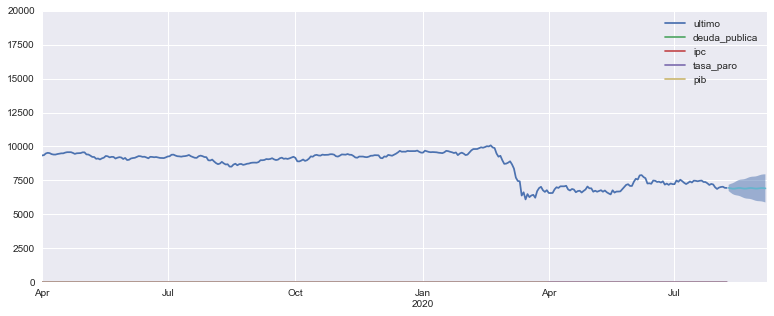

In [49]:
y_pred_with_predict = model02_st_arima313.get_forecast(20, 
                                                       exog=train_with_predict.iloc[train_with_predict.shape[0]-20:,-4:])

lower_with_predict = y_pred_with_predict.conf_int()["lower ultimo"]
upper_with_predict = y_pred_with_predict.conf_int()["upper ultimo"]
train_with_predict.truncate(before = "2019").plot()

y_pred_with_predict.predicted_mean.plot()
plt.fill_between(lower_with_predict.index, lower_with_predict, upper_with_predict, alpha=0.5)
plt.axis(['2019-04-01','2020-09-5',0,20000])
plt.show()

Finalmente vamos a calcular el MSE para validar como de bueno es nuestro modelo y poderlo comparar con el resto de modelos.

In [50]:
# Finalmente debemos comprobar cómo de eficiente es nuestro modelo
# MSE: Mean squared error
print("- TRAIN -")
print("Mean squared error: %.2f" % metrics.mean_squared_error(train_with_predict.ultimo, model02_st_arima313.fittedvalues))

- TRAIN -
Mean squared error: 86745.40


Aplicamos la técnica de Cross Validation sobre los datos de train; como nuestras observaciones no son independientes no podemos dividir los datos al azar utilizando K-folds para ello será necesario utilizar TimeSeriesSplit de Scikit-learn.
TimeSeriesSplit es una variante adaptada de K-folds que va iterando los "folds" de uno a uno (usando una ventana de tiempo que se desplaza) y usando el "fold más reciente" como el set de validación.

In [51]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for train_index, test_index in tscv.split(train_with_predict):
    X_tr, X_val = train_with_predict.iloc[train_index, :], train_with_predict.iloc[test_index, :]
    y_tr, y_val = train_with_predict.iloc[train_index], train_with_predict.iloc[test_index]
    model = SARIMAX(X_tr.iloc[:, 0], 
                         exog=X_tr.iloc[:,1:], 
                         order=(3,1,3),
                         #seasonal_order=(0,0,0,0),
                         freq='B',
                         enforce_stationary=False,
                         enforce_invertibility=False).fit()
    score.append(metrics.mean_squared_error(X_tr.ultimo, model.fittedvalues))
    
print("- TRAIN -")
print("Cross-Validation > Mean squared error: %.2f" % np.mean(np.array(score)))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


- TRAIN -
Cross-Validation > Mean squared error: 281203.68


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Guardamos el modelo para usarlo posteriormente con los valores de test:

In [52]:
path_model_save = "./models/arima313_fit_ultimo_filter_data_deuda_publica+ipc+tasa_paro+pib_python.pkl"  
joblib.dump(model02_st_arima313, path_model_save)

['./models/arima313_fit_ultimo_filter_data_deuda_publica+ipc+tasa_paro+pib_python.pkl']

Cargamos el modelo guardado para usarlo con los modelos de test:

In [53]:
model02_st_arima313 = joblib.load(path_model_save)

Ahora sobre el modelo entrenado vamos a predecir valores sobre el dataset de test. Como podemos observar las prediciones no son muy buenas pero hay que tener en cuenta que durante ese periodo se produjo la crisis del COVID-19 

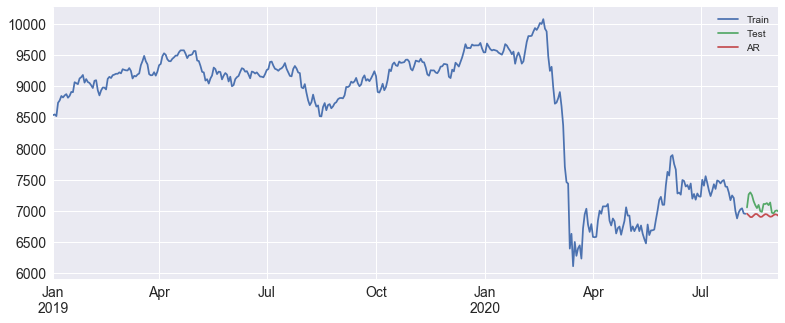

In [54]:
# Segundo modelo de Series temporales > AR (Modelo autorregresivo)
y_pred_test_with_predict2 = test_with_predict.to_timestamp()
y_pred_test_with_predict = y_pred_test_with_predict2.copy()
y_pred_test_with_predict['AR'] = model02_st_arima313.predict(n_periods=len(y_pred_test_with_predict2), 
                                                             start=y_pred_test_with_predict2.index.min(), 
                                                             end=y_pred_test_with_predict2.index.max(),
                                                             exog=test_with_predict.iloc[:,-4:],
                                                             dynamic=False)
y_pred_test_with_predict

plt.figure(figsize=(16,8))
train_with_predict.ultimo.truncate(before = "2019").plot(figsize=(13,5), label='Train', fontsize=14)
test_with_predict.ultimo.plot(figsize=(13,5), label='Test', fontsize=14)
y_pred_test_with_predict.AR.plot(figsize=(13,5), label='AR', fontsize=14)
plt.legend(loc='best')
plt.show()

In [55]:
# Finalmente debemos comprobar cómo de eficiente es nuestro modelo sobre los datos de test
# MSE: Mean squared error
print("- TEST -")
print("Mean squared error: %.2f" % metrics.mean_squared_error(test_with_predict.ultimo, 
                                                              y_pred_test_with_predict.AR))

- TEST -
Mean squared error: 36145.24


El siguiente punto será evaluar los residuos obtenidos en el modelo; los cuales deben aproximarse al comportamiento de ruido blanco. Deben presentar media cero, varianza constante y convarianza cero (incorrelación).

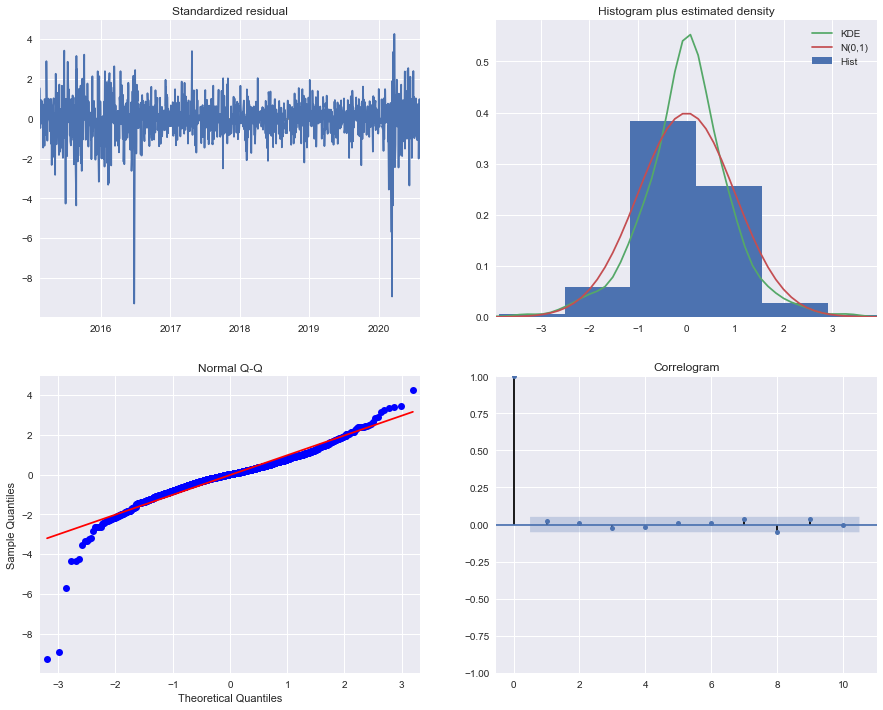

In [56]:
model02_st_arima313.plot_diagnostics(figsize=(15, 12))
plt.show()

- Gráfica Standardized residual: podemos observar que los residuos giran alrededor de una media cero.
- Gráfica Histogram plus estimated density: podemos observar que se comportan de manera aproximadamente normal.
- Gráfica Normal Q-Q: podemos observar que se comportan de manera aproximadamente normal. 
- Gráfica Correlogram: podemos observar que no existe correlación entre los residuos del modelo.


Ploteamos los residuos
Podemos observar en las gráficas que existe poca autocorrelación.

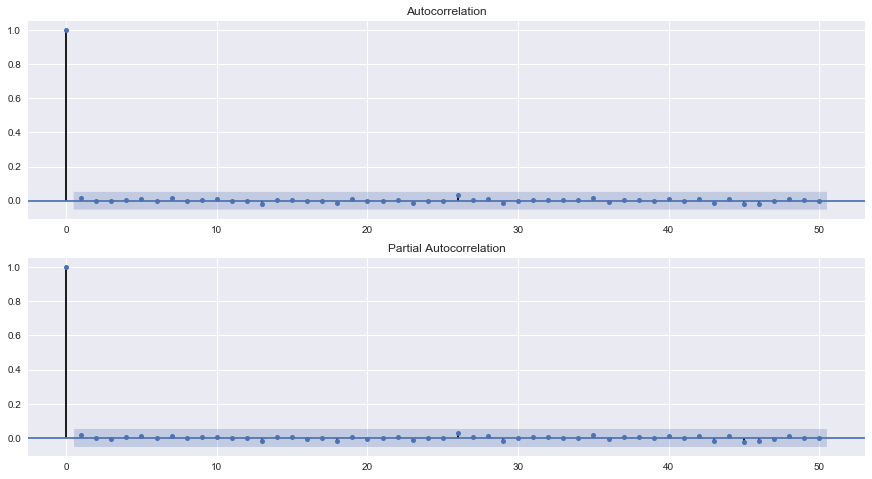

In [57]:
res = model02_st_arima313.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

## Ajuste de un modelo SARIMA(p,d,q)x(P,D,Q)s

Este modelo (Seasonal autoregressive integrated moving average) captura la particularidad estacional y cíclica de nuestra serie de interés (la parte cíclica es la asociada al componente autorregresivo y de media móvil).
Serie temporal estacional dónde:
    - (p,d,q) se trata de la parte o retardos regulares 
    - (P,D,Q)s se trata de la parte estacional y s es el número de observaciones por año
    
Los modelos SARIMA tienen los momentos y correlogramas iguales que los ARIMA pero en vez de considerar los retardos regulares nos fijaremos en los retardos estacionales.

Aunque no podemos observar un patrón sistemático que se repite periódicamente de forma clara, vamos a probar ya que en los datos económicas es muy frecuente tener una fuerte componente estacional y no estacionarios.

En este dataset como el periodo es B (business day frequency) de Lúnes a Viernes el valor para s sería de 52 (número de observaciones por año).

In [58]:
p = q = range(0,2)
pq = [(x[0], 0, x[1], 52) for x in list (itertools.product(p,q))]
res_parameters = []
for param in pq:
    try:
        mod=SARIMAX(train, 
                    order=(2,1,3),
                    seasonal_order=param,
                    freq='B',
                    enforce_stationary=False,
                    enforce_invertibility=False)
        results = mod.fit()
        res_parameters.append({'param': param, 'aic': results.aic, 'bic': results.bic})
    except:
        continue

res_aic_bic = pd.DataFrame(res_parameters)
print("Parámetros p y q que minimizan la paramétrica AIC:")
print(res_aic_bic[res_aic_bic.aic == res_aic_bic.aic.min()])
print("\nParámetros p y q que minimizan la paramétrica BIC:")
print(res_aic_bic[res_aic_bic.bic == res_aic_bic.bic.min()])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Parámetros p y q que minimizan la paramétrica AIC:
           param           aic           bic
2  (1, 0, 0, 52)  17649.371675  17686.234576

Parámetros p y q que minimizan la paramétrica BIC:
           param           aic           bic
0  (0, 0, 0, 52)  17651.982129  17683.578902


En nuestro caso como comentamos anteriormente vamos a tener en cuenta los parámetros que retornen un menor AIC; en este caso el modelo SARIMA resultante sería (2,1,3)(1,0,0,52).

### 03. Entrenamiento modelo SARIMA(2,1,3)(1,0,0,52) y representación de los resultados para un único predictor

In [59]:
# Tercer modelo de Series temporales > SARIMA (Modelo ARIMA estacional)
model03_st_sarima213100 = SARIMAX(train.to_timestamp(), 
                                  order=(2,1,3), 
                                  seasonal_order=(1,0,0,52),
                                  freq='B',
                                  enforce_stationary=False,
                                  enforce_invertibility=False).fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [60]:
model03_st_sarima213100.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             ultimo   No. Observations:                 1432
Model:             SARIMAX(2, 1, 3)x(1, 0, 0, 52)   Log Likelihood               -8817.686
Date:                            Sat, 05 Sep 2020   AIC                          17649.372
Time:                                    11:37:55   BIC                          17686.235
Sample:                                02-12-2015   HQIC                         17663.137
                                     - 08-07-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9374      0.019     49.144      0.000       0.900       0.975
ar.L2         -0.9520      0.018    -52.022      0.000      -0.988      -0.916
ma.L1         -0.9290      0.025    -36.483      0.000      -0.979      -0.879
ma.L2          0.9740      0.023     43.218      0.000       0.930       1.018
ma.L3          0.0054      0.020      0.272      0.785      -0.034       0.044
ar.S.L52      -0.0617      0.025     -2.422      0.015      -0.112      -0.012
sigma2      1.332e+04    254.045     52.422      0.000    1.28e+04    1.38e+04
===================================================================================
Ljung-Box (Q):                       36.43   Jarque-Bera (JB):              8088.00
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

En este resumen de los datos debemos centrar la atención en la columna coef; esta nos muestra la importancia de cada característica y cómo afecta a la serie temporal. El p-value también nos muestra el nivel de significancia del peso de cada variable. En este caso todos los p-value tienen un valor menor de 0.5 a excepción de ma.L3; sería necesario quitarlo y probar para poder rechazar la hipótesis nula.

El siguiente punto será evaluar los residuos obtenidos en el modelo; los cuales deben aproximarse al comportamiento de ruido blanco. Deben presentar media cero, varianza constante y convarianza cero (incorrelación).

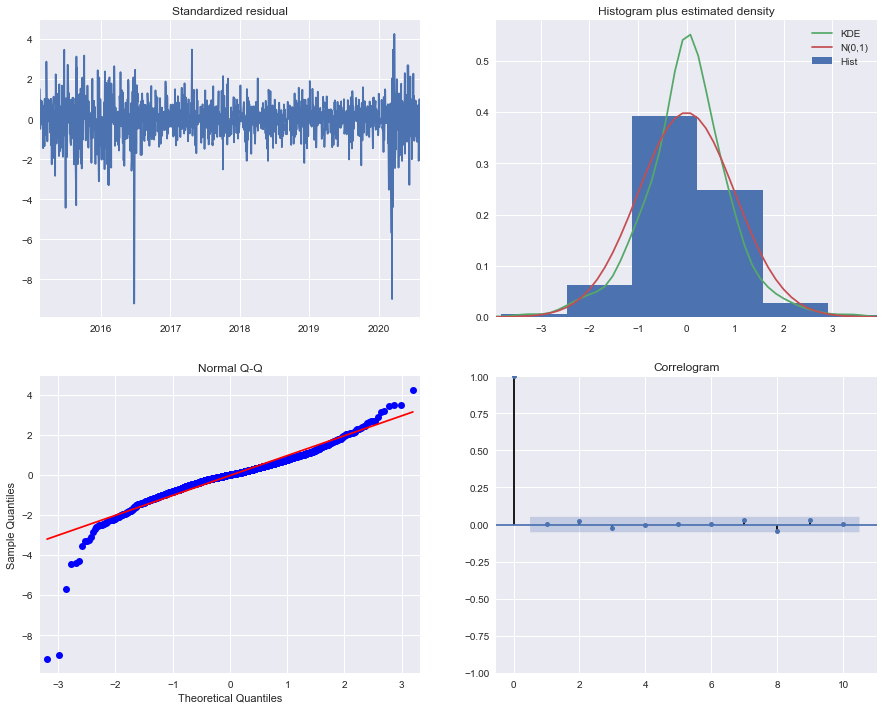

In [61]:
model03_st_sarima213100.plot_diagnostics(figsize=(15, 12))
plt.show()

- Gráfica Standardized residual: podemos observar que los residuos giran alrededor de una media cero.
- Gráfica Histogram plus estimated density: podemos observar que se comportan de manera aproximadamente normal.
- Gráfica Normal Q-Q: podemos observar que se comportan de manera aproximadamente normal. 
- Gráfica Correlogram: podemos observar que no existe correlación entre los residuos del modelo.

A continuación vamos a predicir una serie de resultados y plotear los resultados mostrando los resultados de confianza sobre dichas prediciones.

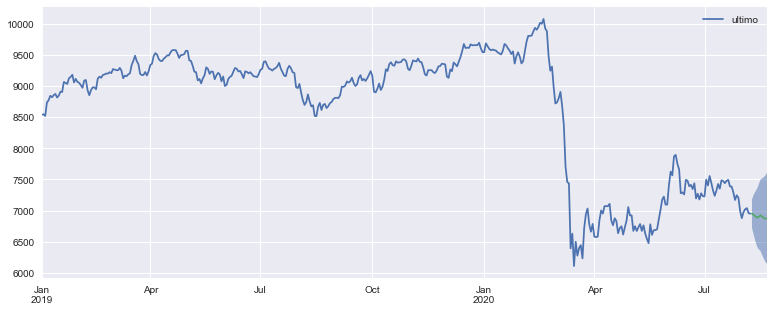

In [62]:
y_pred = model03_st_sarima213100.get_forecast(10)

lower = y_pred.conf_int()["lower ultimo"]
upper = y_pred.conf_int()["upper ultimo"]
train.truncate(before = "2019").plot()

y_pred.predicted_mean.plot()
plt.fill_between(lower.index, lower, upper, alpha =0.5)
plt.show()

Finalmente vamos a calcular el MSE para validar como de bueno es nuestro modelo y poderlo comparar con el resto de modelos.

In [63]:
# Finalmente debemos comprobar cómo de eficiente es nuestro modelo
# MSE: Mean squared error
print("- TRAIN -")
print("Mean squared error: %.2f" % metrics.mean_squared_error(train.ultimo, model03_st_sarima213100.fittedvalues))

- TRAIN -
Mean squared error: 91067.72


Aplicamos la técnica de Cross Validation sobre los datos de train; como nuestras observaciones no son independientes no podemos dividir los datos al azar utilizando K-folds para ello será necesario utilizar TimeSeriesSplit de Scikit-learn.
TimeSeriesSplit es una variante adaptada de K-folds que va iterando los "folds" de uno a uno (usando una ventana de tiempo que se desplaza) y usando el "fold más reciente" como el set de validación.

In [64]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for train_index, test_index in tscv.split(train):
    X_tr, X_val = train.iloc[train_index, :], train.iloc[test_index, :]
    y_tr, y_val = train.iloc[train_index], train.iloc[test_index]
    model = SARIMAX(X_tr.to_timestamp(), 
                    order=(2,1,3), 
                    seasonal_order=(1,0,0,52),
                    freq='B',
                    enforce_stationary=False,
                    enforce_invertibility=False).fit()
    score.append(metrics.mean_squared_error(X_tr.ultimo, model.fittedvalues))
    
print("- TRAIN -")
print("Cross-Validation > Mean squared error: %.2f" % np.mean(np.array(score)))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


- TRAIN -
Cross-Validation > Mean squared error: 227050.16


Guardamos el modelo para usarlo posteriormente con los valores de test:

In [65]:
path_model_save = "./models/sarima213100_fit_ultimo_python.pkl"  
joblib.dump(model03_st_sarima213100, path_model_save)

['./models/sarima213100_fit_ultimo_filter_data_deuda_publica+ipc+tasa_paro+pib_python.pkl']

Cargamos el modelo guardado para usarlo con los modelos de test:

In [66]:
model03_st_sarima213100 = joblib.load(path_model_save)

Ahora sobre el modelo entrenado vamos a predecir valores sobre el dataset de test. Como podemos observar las prediciones no son muy buenas pero hay que tener en cuenta que durante ese periodo se produjo la crisis del COVID-19

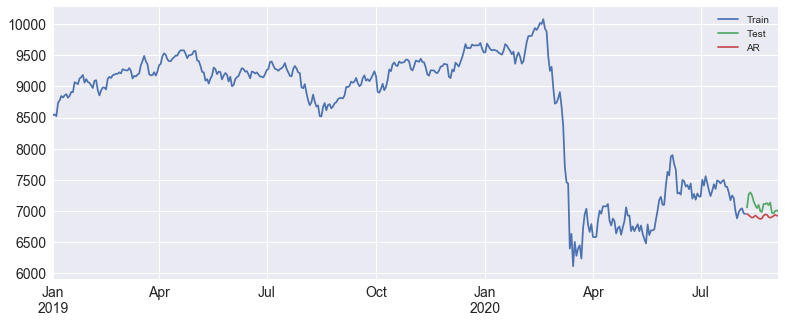

In [67]:
# Tercer modelo de Series temporales > SARIMA (Modelo ARIMA estacional)
test2 = test.to_timestamp()
y_pred_test = test2.copy()
y_pred_test['AR'] = model03_st_sarima213100.predict(n_periods=len(test2), start=test2.index.min(), end=test2.index.max())
y_pred_test

plt.figure(figsize=(16,8))
train.ultimo.truncate(before = "2019").plot(figsize=(13,5), label='Train', fontsize=14)
test.ultimo.plot(figsize=(13,5), label='Test', fontsize=14)
y_pred_test.AR.plot(figsize=(13,5), label='AR', fontsize=14)
plt.legend(loc='best')
plt.show()

In [68]:
# Finalmente debemos comprobar cómo de eficiente es nuestro modelo sobre los datos de test
# MSE: Mean squared error
print("- TEST -")
print("Mean squared error: %.2f" % metrics.mean_squared_error(test.ultimo, y_pred_test.AR))

- TEST -
Mean squared error: 40274.23


Si nos fijamos el MSE en train es de 227050,16 mientras que el MSE en test es de 40274.23; si este valor estuviera por encima del MSE de train esto sería un indicador de que nuestro modelo no ha entrenado bien y no nos sirve. Podría tratarse de un caso de Overfiting.

### 04. Entrenamiento modelo SARIMA(3,1,3)(P,D,Q,52) y representación de los resultados para los predictores deuda_publica, ipc, tasa_paro y pib

Lo primero que tenemos que hacer es obtener el dataset con los datos que necesitamos.

In [69]:
data_total_with_predict = get_all_historic_data('IBEX35',True)
data_total_with_predict = transform_data(data_total_with_predict, ['maximo', 'minimo', 'variacion', 'apertura','vol'], 
                                         {"ultimo": float, "deuda_publica": float, "ipc": float, "tasa_paro": float, 
                                         "pib": float})
data_total_with_predict = fill_pending_dates(data_total_with_predict, "B")
data_total_with_predict.head()

,ultimo,deuda_publica,ipc,tasa_paro,pib
2015-02-12,10562.2,1044720.44,-1.07,23.78,1.15
2015-02-13,10739.5,1044720.44,-1.07,23.78,1.15
2015-02-16,10689.5,1044720.44,-1.07,23.78,1.15
2015-02-17,10698.0,1044720.44,-1.07,23.78,1.15
2015-02-18,10805.3,1044720.44,-1.07,23.78,1.15


En nuestra caso la serie temporal tiene un periodo B (días laborales); establecemos dicho periodo y mostramos la información de forma gráfica.

In [70]:
# Establecemos el periodo B (business day frequency) de Lúnes a Viernes
data_total_with_predict = data_total_with_predict.to_period("B")
# Existen periodos de muchos tipos
data_total_with_predict.head()

,ultimo,deuda_publica,ipc,tasa_paro,pib
2015-02-12,10562.2,1044720.44,-1.07,23.78,1.15
2015-02-13,10739.5,1044720.44,-1.07,23.78,1.15
2015-02-16,10689.5,1044720.44,-1.07,23.78,1.15
2015-02-17,10698.0,1044720.44,-1.07,23.78,1.15
2015-02-18,10805.3,1044720.44,-1.07,23.78,1.15


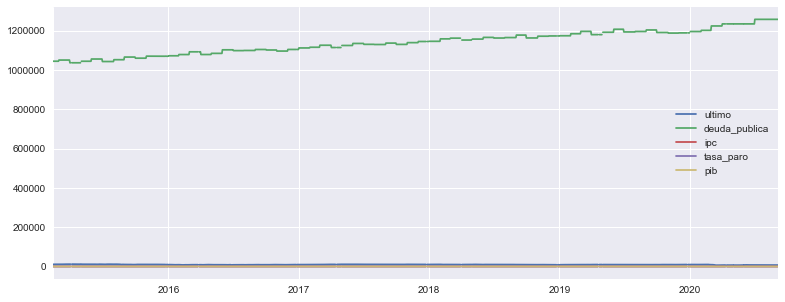

In [71]:
fig, ax = plt.subplots(figsize=(13,5))
# Para no escribir este tamaño siempre se va a establecer una variable de configuración y todas las figuras saldrán 
# de ese tamaño sin necesidad de escribir la primera línea
plt.rcParams["figure.figsize"] = (13,5)
data_total_with_predict.plot(ax=ax);

Será necesario rellenar los valores núlos de las variables exogenous; para ello vamos a utilizar el método "forward fill" (los valores no nulos se copian hacia adelante siempre que se encuentren valores nulos).

In [72]:
# Utilizamos la función fillna() con el método "forward fill" de forma que los valores no nulos se copien hacia
# adelante siempre que se encuentren valores nulos.
data_total_with_predict.fillna(method='ffill', inplace=True)

In [73]:
# Definimos los datos de train y test
train_with_predict = data_total_with_predict[0:1432]
test_with_predict = data_total_with_predict[1432:]

El siguiente paso será estimar los parámetros P, D y Q para el modelo SARIMA(). Para escoger cuál de los distintas opciones vamos a escoger nos vamos a basar en el crítero AIC.
- Criterio BIC: trata de seleccionar el modelo correcto, con máxima probabilidad a posteriori, y puede demostrarse que es un criterio consistente de manera que la probabilidad de seleccionar el modelo correcto tiende a 1 cuando aumenta el tamaño muestral. Asume que el modelo real está incluido en el conjunto de modelos candidatos, y mide el grado de certeza de que un cierto modelo sea el verdadero modelo generador de los datos.
- Critero AIC: no pretende seleccionar el modelo correcto, ya que admite que el modelo verdadero puede no estar entre los estimados tratando de obtener el modelo que proporcione mejores predicciones entre los existentes. No asume que ninguno de los modelos candidatos sea necesariamente el verdadero, calculando para cada modelo la información o discrepancia de Kullback-Leibler, que es una medida de la distancia entre la densidad de probabilidad generada por el modelo y la realidad.

In [74]:
p = d = q = range(0,2)
pdq = [(x[0], x[1], x[2], 52) for x in list (itertools.product(p,d,q))]
res_parameters_with_predict = []
for param in pdq:
    try:
        mod=SARIMAX(train_with_predict.iloc[:, 0],
                    exog=train_with_predict.iloc[:,1:],
                    order=(3,1,3),
                    seasonal_order=param,
                    freq='B',
                    enforce_stationary=False,
                    enforce_invertibility=False)
        results = mod.fit()
        res_parameters_with_predict.append({'param': param, 'aic': results.aic, 'bic': results.bic})
    except:
        continue

res_aic_bic_with_predict = pd.DataFrame(res_parameters_with_predict)
print("Parámetros p y q que minimizan la paramétrica AIC:")
print(res_aic_bic_with_predict[res_aic_bic_with_predict.aic == res_aic_bic_with_predict.aic.min()])
print("\nParámetros p y q que minimizan la paramétrica BIC:")
print(res_aic_bic_with_predict[res_aic_bic_with_predict.bic == res_aic_bic_with_predict.bic.min()])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization fa

Parámetros p y q que minimizan la paramétrica AIC:
           param           aic           bic
3  (0, 1, 1, 52)  17294.141934  17356.891301

Parámetros p y q que minimizan la paramétrica BIC:
           param           aic           bic
3  (0, 1, 1, 52)  17294.141934  17356.891301


Entrenamos el modelo SARIMA(3,1,3)(0,1,1,52) con nuestras variables exogenas.

In [75]:
# Cuarto modelo de Series temporales > SARIMA(3,1,3)(0,1,1,52)
train_with_predict = train_with_predict.to_timestamp()
model04_st_sarima313011 = SARIMAX(train_with_predict.iloc[:, 0], 
                         exog=train_with_predict.iloc[:,1:], 
                         order=(3,1,3),
                         seasonal_order=(0,1,1,52),
                         freq='B',
                         enforce_stationary=False,
                         enforce_invertibility=False).fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [76]:
model04_st_sarima313011.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             ultimo   No. Observations:                 1432
Model:             SARIMAX(3, 1, 3)x(0, 1, 1, 52)   Log Likelihood               -8635.071
Date:                            Sun, 06 Sep 2020   AIC                          17294.142
Time:                                    10:44:37   BIC                          17356.891
Sample:                                02-12-2015   HQIC                         17317.617
                                     - 08-07-2020                                         
Covariance Type:                              opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
deuda_publica     0.0035      0.003      1.348      0.178      -0.002       0.008
ipc              47.2859     51.793      0.913      0.361     -54.227     148.799
tasa_paro       -50.4568     46.540     -1.084      0.278    -141.674      40.760
pib              -2.6347      9.107     -0.289      0.772     -20.484      15.214
ar.L1            -0.8454      0.067    -12.568      0.000      -0.977      -0.714
ar.L2             0.8044      0.096      8.410      0.000       0.617       0.992
ar.L3             0.9353      0.058     16.061      0.000       0.821       1.049
ma.L1             0.8523      0.065     13.138      0.000       0.725       0.979
ma.L2            -0.8232      0.092     -8.978      0.000      -1.003      -0.643
ma.L3            -0.9497      0.056    -17.041      0.000      -1.059      -0.841
ma.S.L52         -0.8968      0.032    -28.063      0.000      -0.959      -0.834
sigma2         2.022e+04    542.893     37.246      0.000    1.92e+04    2.13e+04
===================================================================================
Ljung-Box (Q):                       47.53   Jarque-Bera (JB):              7816.88
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -1.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

En este resumen de los datos debemos centrar la atención en la columna coef; esta nos muestra la importancia de cada característica y cómo afecta a la serie temporal. El p-value también nos muestra el nivel de significancia del peso de cada variable. En este caso la variable pib tienen un valor de p-value superior a 0.5; sería necesario quitarla y probar para poder rechazar la hipótesis nula.

A continuación vamos a predicir una serie de resultados y plotear los resultados mostrando los resultados de confianza sobre dichas prediciones.

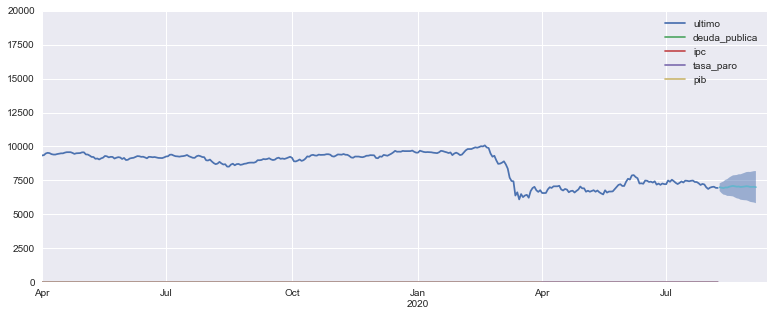

In [77]:
y_pred_with_predict = model04_st_sarima313011.get_forecast(20, 
                                                       exog=train_with_predict.iloc[train_with_predict.shape[0]-20:,-4:])

lower_with_predict = y_pred_with_predict.conf_int()["lower ultimo"]
upper_with_predict = y_pred_with_predict.conf_int()["upper ultimo"]
train_with_predict.truncate(before = "2019").plot()

y_pred_with_predict.predicted_mean.plot()
plt.fill_between(lower_with_predict.index, lower_with_predict, upper_with_predict, alpha=0.5)
plt.axis(['2019-04-01','2020-09-12',0,20000])
plt.show()

Finalmente vamos a calcular el MSE para validar como de bueno es nuestro modelo y poderlo comparar con el resto de modelos.

In [78]:
# Finalmente debemos comprobar cómo de eficiente es nuestro modelo
# MSE: Mean squared error
print("- TRAIN -")
print("Mean squared error: %.2f" % metrics.mean_squared_error(train_with_predict.ultimo, model04_st_sarima313011.fittedvalues))

- TRAIN -
Mean squared error: 73644.54


Aplicamos la técnica de Cross Validation sobre los datos de train; como nuestras observaciones no son independientes no podemos dividir los datos al azar utilizando K-folds para ello será necesario utilizar TimeSeriesSplit de Scikit-learn. TimeSeriesSplit es una variante adaptada de K-folds que va iterando los "folds" de uno a uno (usando una ventana de tiempo que se desplaza) y usando el "fold más reciente" como el set de validación.

In [79]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for train_index, test_index in tscv.split(train_with_predict):
    X_tr, X_val = train_with_predict.iloc[train_index, :], train_with_predict.iloc[test_index, :]
    y_tr, y_val = train_with_predict.iloc[train_index], train_with_predict.iloc[test_index]
    model = SARIMAX(X_tr.iloc[:, 0], 
                         exog=X_tr.iloc[:,1:], 
                         order=(3,1,3),
                         seasonal_order=(0,1,1,52),
                         freq='B',
                         enforce_stationary=False,
                         enforce_invertibility=False).fit()
    score.append(metrics.mean_squared_error(X_tr.ultimo, model.fittedvalues))
    
print("- TRAIN -")
print("Cross-Validation > Mean squared error: %.2f" % np.mean(np.array(score)))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

- TRAIN -
Cross-Validation > Mean squared error: 413995.02


Guardamos el modelo para usarlo posteriormente con los valores de test:

In [80]:
path_model_save = "./models/sarima313011_fit_ultimo_filter_data_deuda_publica+ipc+tasa_paro+pib_python.pkl"  
joblib.dump(model04_st_sarima313011, path_model_save)

['./models/sarima313011_fit_ultimo_filter_data_deuda_publica+ipc+tasa_paro+pib_python.pkl']

Cargamos el modelo guardado para usarlo con los modelos de test:

In [81]:
model04_st_sarima313011 = joblib.load(path_model_save)

Ahora sobre el modelo entrenado vamos a predecir valores sobre el dataset de test. Como podemos observar las prediciones no son muy buenas pero hay que tener en cuenta que durante ese periodo se produjo la crisis del COVID-19

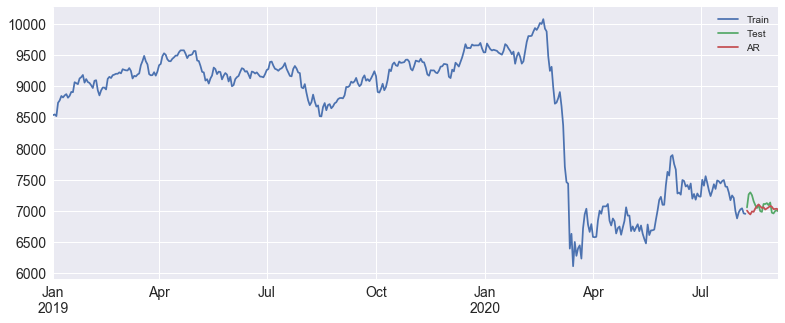

In [82]:
# Cuarto modelo de Series temporales > SARIMA(3,1,3)(0,1,1,52)
y_pred_test_with_predict2 = test_with_predict.to_timestamp()
y_pred_test_with_predict = y_pred_test_with_predict2.copy()
y_pred_test_with_predict['AR'] = model04_st_sarima313011.predict(n_periods=len(y_pred_test_with_predict2), 
                                                             start=y_pred_test_with_predict2.index.min(), 
                                                             end=y_pred_test_with_predict2.index.max(),
                                                             exog=test_with_predict.iloc[:,-4:],
                                                             dynamic=False)
y_pred_test_with_predict

plt.figure(figsize=(16,8))
train_with_predict.ultimo.truncate(before = "2019").plot(figsize=(13,5), label='Train', fontsize=14)
test_with_predict.ultimo.plot(figsize=(13,5), label='Test', fontsize=14)
y_pred_test_with_predict.AR.plot(figsize=(13,5), label='AR', fontsize=14)
plt.legend(loc='best')
plt.show()

In [83]:
# Finalmente debemos comprobar cómo de eficiente es nuestro modelo sobre los datos de test
# MSE: Mean squared error
print("- TEST -")
print("Mean squared error: %.2f" % metrics.mean_squared_error(test_with_predict.ultimo, 
                                                              y_pred_test_with_predict.AR))

- TEST -
Mean squared error: 18366.52


El siguiente punto será evaluar los residuos obtenidos en el modelo; los cuales deben aproximarse al comportamiento de ruido blanco. Deben presentar media cero, varianza constante y convarianza cero (incorrelación).

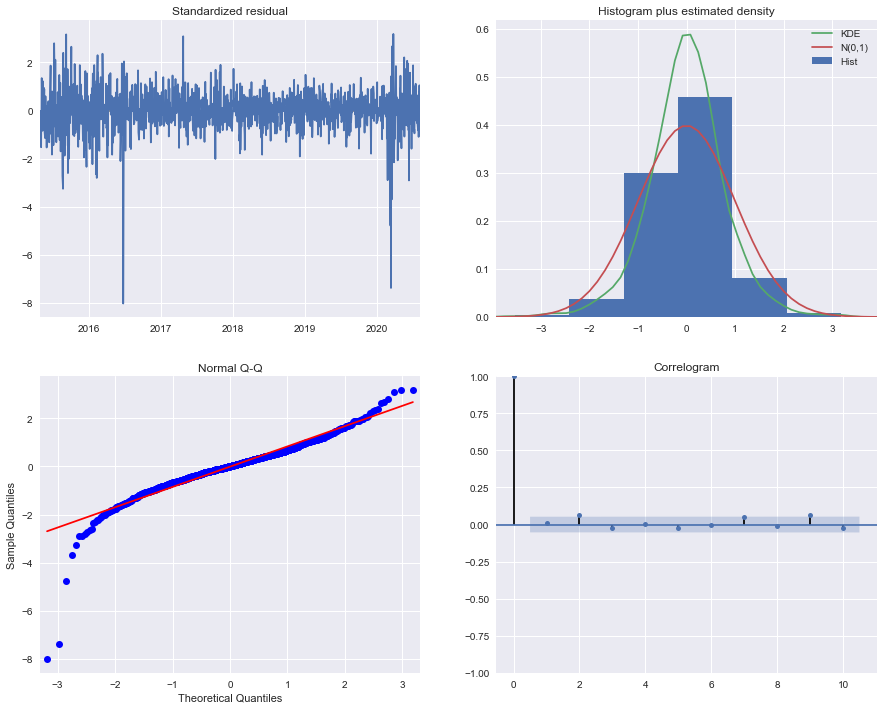

In [84]:
model04_st_sarima313011.plot_diagnostics(figsize=(15, 12))
plt.show()

- Gráfica Standardized residual: podemos observar que los residuos giran alrededor de una media cero.
- Gráfica Histogram plus estimated density: podemos observar que se comportan de manera aproximadamente normal aunque aún la curva verde no se aproxima a la forma gaussiana de la roja.
- Gráfica Normal Q-Q: podemos observar que se comportan de manera aproximadamente normal. 
- Gráfica Correlogram: podemos observar que no existe correlación entre los residuos del modelo.


Ploteamos los residuos
Podemos observar en las gráficas que existe poca autocorrelación.

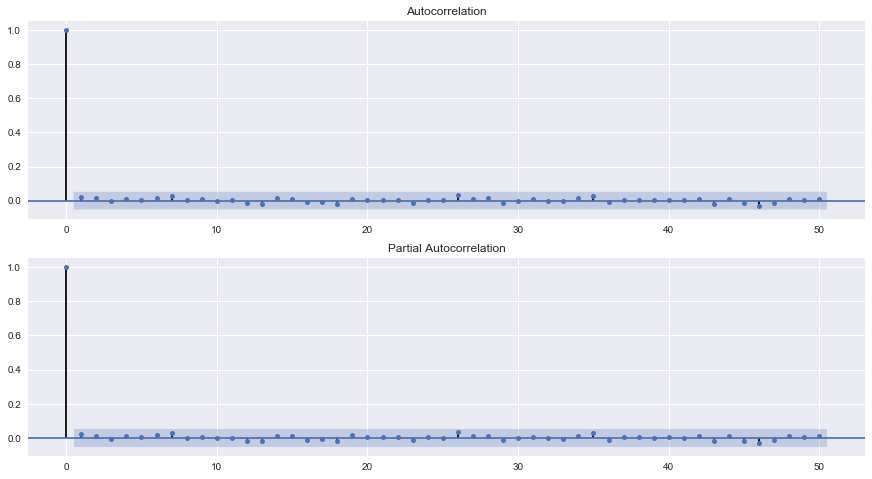

In [85]:
res = model04_st_sarima313011.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()